In [1]:
import sys

sys.path.append("../..")
import csv
import glob
import os
import threading
from typing import List

import SimpleITK as sitk
import numpy as np
import pandas as pd
import pingouin as pg
from scipy import ndimage
import glob
import os
import seaborn as sns
# sns.set_theme(color_codes=True)

import matplotlib
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import cohen_kappa_score

import lung_function.modules.my_bland as sm
from lung_function.modules.path import PFTPath

# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt


/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [38]:
# take 1403_fold1 as the example
mypath = PFTPath(1387, check_id_dir=False, space='ori')
mode='valid'
label_fpath = mypath.save_label_fpath(mode)
pred_fpath = mypath.save_pred_fpath(mode)
ignore_1st_column = True

In [39]:
label_fpath

'/home/jjia/data/lung_function/lung_function/scripts/results/experiments/1387/valid_label.csv'

In [40]:
icc_dict = {}

label = pd.read_csv(label_fpath)
pred = pd.read_csv(pred_fpath)
if ignore_1st_column:
    pred = pred.iloc[: , 1:]
    label = label.iloc[: , 1:]
if 'ID' == label.columns[0]:
    del label["ID"]
if 'ID' == pred.columns[0]:
    del pred["ID"]


In [41]:
pred

,FVC,DLCO_SB,FEV1,TLC_He
0,1.348,1.816,0.9956,2.150
1,2.766,4.695,2.1300,3.871
2,2.480,3.746,1.8460,3.758
3,3.191,5.066,2.3980,4.740
4,2.209,3.424,1.6660,3.287
...,...,...,...,...
58,2.543,4.105,1.9340,3.695
59,2.860,4.887,2.2190,3.960
60,2.797,4.800,2.1780,3.865
61,2.242,3.690,1.7100,3.248


In [42]:
label

,FVC,DLCO_SB,FEV1,TLC_He
0,2.752,6.502,2.507,3.619
1,3.501,7.433,2.982,4.401
2,2.738,5.531,1.827,5.064
3,4.519,6.942,3.611,6.180
4,3.480,3.926,2.596,5.350
...,...,...,...,...
58,3.181,4.441,2.218,5.362
59,4.153,7.087,3.135,5.585
60,3.204,6.731,3.200,5.525
61,2.349,3.230,1.660,3.131


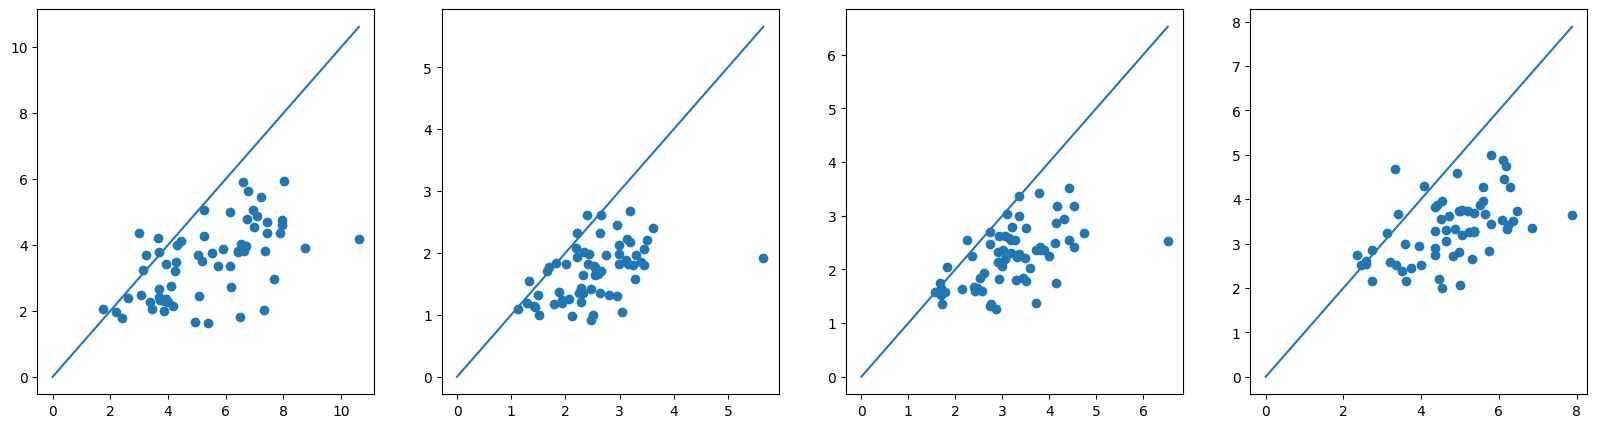

In [43]:
%matplotlib inline
fg = plt.figure(figsize=(20,5))
for idx, i in enumerate(['DLCO_SB', 'FEV1', 'FVC', 'TLC_He']):
    ax = fg.add_subplot(1,4,idx+1) 

    ax.scatter(label[i], pred[i])
    max_v = max(label[i].max(), pred[i].max())
    # print(max_v)
    ax.plot([0,max_v], [0, max_v])
plt.show()

In [44]:
max_v

7.883

In [45]:

original_columns = label.columns

# ori_columns = list(label.columns)

label['ID'] = np.arange(1, len(label) + 1)
label['rater'] = 'label'

pred['ID'] = np.arange(1, len(pred) + 1)
pred['rater'] = 'pred'

data = pd.concat([label, pred], axis=0)

for column in original_columns:
    icc = pg.intraclass_corr(data=data, targets='ID', raters='rater', ratings=column).round(2)
    icc = icc.set_index("Type")
    icc = icc.loc['ICC2']['ICC']
    prefix = label_fpath.split("/")[-1].split("_")[0]
    icc_dict['icc_' + prefix + '_' + column] = icc

In [46]:
icc_dict

{'icc_valid_FVC': 0.28,
 'icc_valid_DLCO_SB': 0.3,
 'icc_valid_FEV1': 0.22,
 'icc_valid_TLC_He': 0.22}